In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [ ]:
# Load images
img1 = cv2.imread("asm-1.jpg")
img2 = cv2.imread("asm-2.jpg")
# Print sizes
print("asm-1 shape:", img1.shape)
print("asm-2 shape:", img2.shape)

# Display using OpenCV windows
cv2.imshow("ASM Image 1", img1)
cv2.imshow("ASM Image 2", img2)

cv2.waitKey(0)
cv2.destroyAllWindows()


asm-1 shape: (428, 639, 3)
asm-2 shape: (427, 640, 3)


In [3]:
# Load pretrained YOLOv8 model
model = YOLO("yolov8n.pt")


def detect_person_bbox(image):
    """
    Detect the largest person in the image using a pretrained YOLOv8 model.
    Returns bounding box as (x, y, w, h).
    """

    results = model(image)          
    boxes = results[0].boxes        

    # Filter only 'person' class (COCO class 0)
    person_boxes = [b for b in boxes if int(b.cls) == 0]

    if len(person_boxes) == 0:
        raise Exception("No person detected!")

    # Select the largest detected person
    areas = []
    for b in person_boxes:
        x1, y1, x2, y2 = b.xyxy[0].cpu().numpy()
        area = (x2 - x1) * (y2 - y1)
        areas.append(area)

    best_idx = np.argmax(areas)
    best_box = person_boxes[best_idx]

    x1, y1, x2, y2 = best_box.xyxy[0].cpu().numpy()

    # Convert to GrabCut format: (x, y, w, h)
    w = int(x2 - x1)
    h = int(y2 - y1)

    return int(x1), int(y1), w, h


In [5]:
# Detect bounding boxes
bbox1 = detect_person_bbox(img1)
bbox2 = detect_person_bbox(img2)

print("Bounding box for asm-1:", bbox1)
print("Bounding box for asm-2:", bbox2)


0: 448x640 1 person, 1 bicycle, 327.3ms
Speed: 12.3ms preprocess, 327.3ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 skateboard, 409.1ms
Speed: 8.7ms preprocess, 409.1ms inference, 2.8ms postprocess per image at shape (1, 3, 448, 640)
Bounding box for asm-1: (261, 64, 92, 237)
Bounding box for asm-2: (193, 36, 255, 231)


In [6]:
def run_grabcut(image, rect, num_iter):
    """
    Run GrabCut segmentation using a bounding box.
    rect = (x, y, w, h)
    num_iter = number of GrabCut iterations
    """
    mask = np.zeros(image.shape[:2], np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)

    cv2.grabCut(image, mask, rect, bgModel, fgModel, num_iter, cv2.GC_INIT_WITH_RECT)

    # Convert mask to binary (1 = foreground, 0 = background)
    final_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype(np.uint8)

    # Extract segmented foreground
    segmented = image * final_mask[:, :, np.newaxis]

    # Overlay mask on original
    overlay = image.copy()
    overlay[:, :, 1] = np.maximum(overlay[:, :, 1], final_mask * 255)

    return final_mask, segmented, overlay

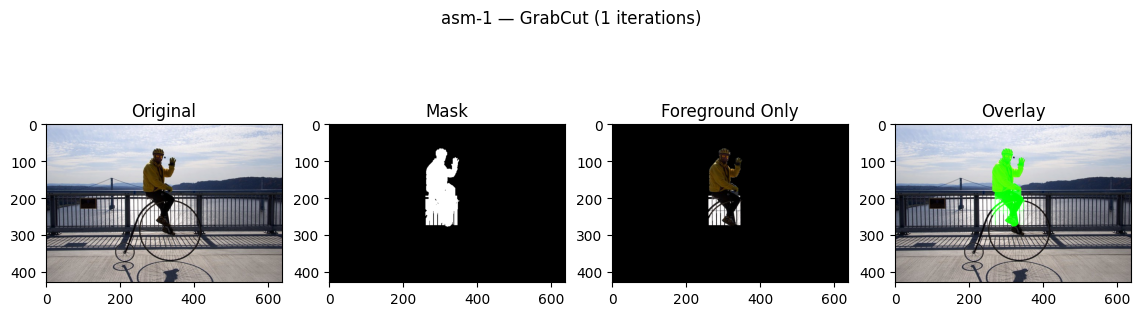

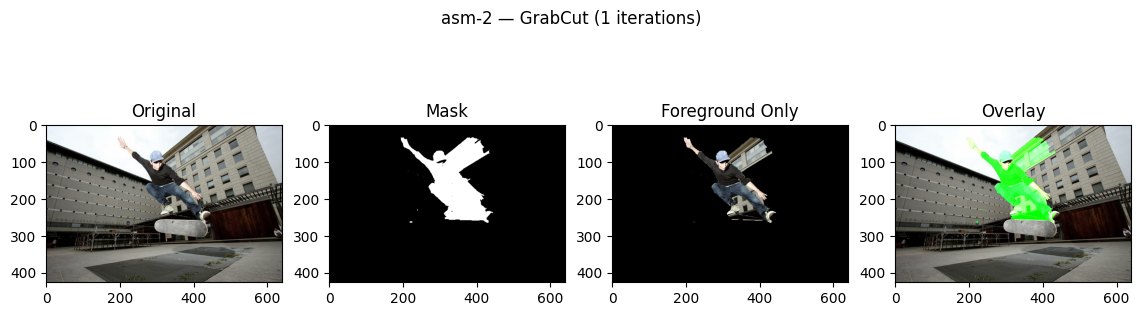

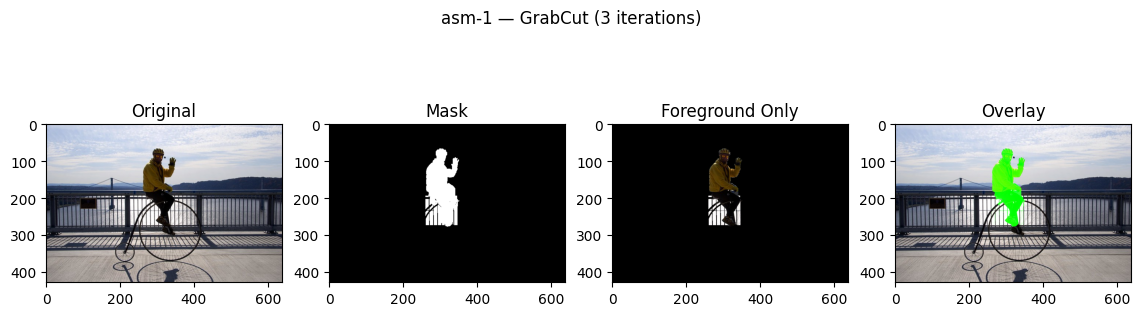

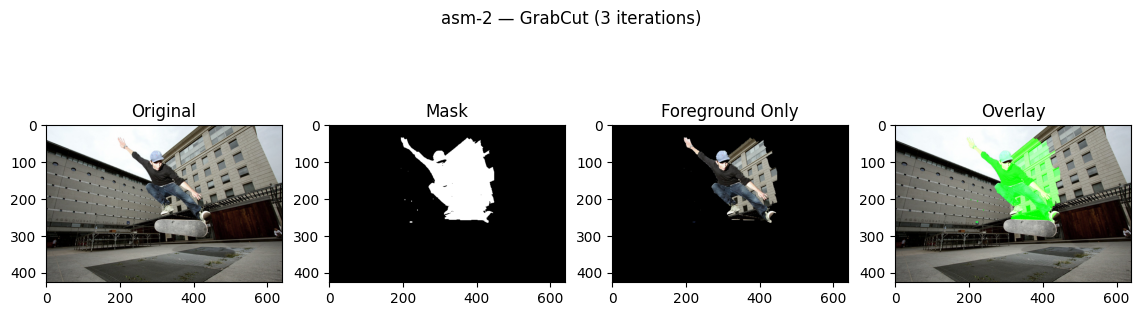

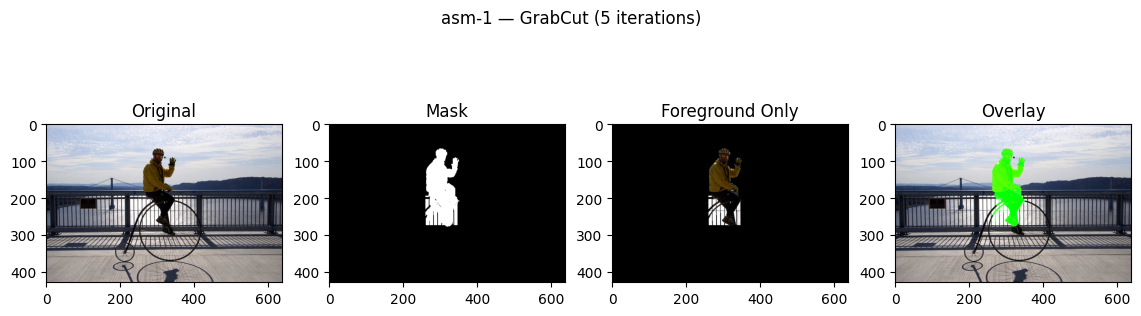

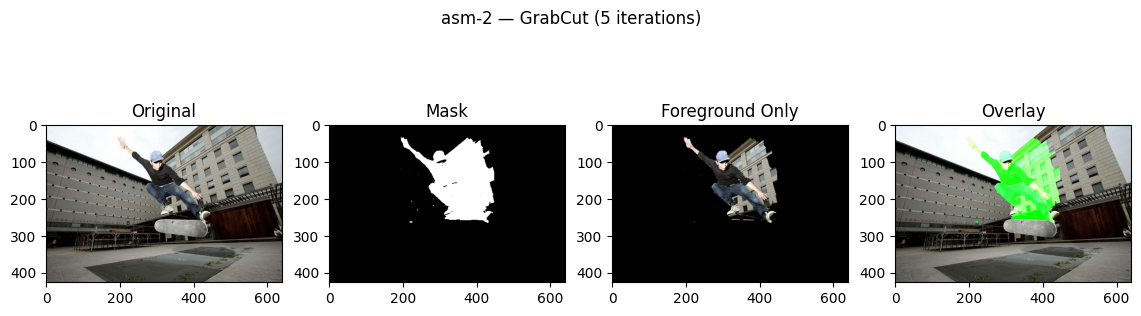

In [7]:
def show_results(img, mask, segmented, overlay, title):
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")

    plt.subplot(1, 4, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask")

    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
    plt.title("Foreground Only")

    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Overlay")

    plt.suptitle(title)
    plt.show()


# --- Apply GrabCut ---
iterations = [1, 3, 5]

for it in iterations:
    mask1, seg1, overlay1 = run_grabcut(img1, bbox1, it)
    show_results(img1, mask1, seg1, overlay1,
                 f"asm-1 — GrabCut ({it} iterations)")

    mask2, seg2, overlay2 = run_grabcut(img2, bbox2, it)
    show_results(img2, mask2, seg2, overlay2,
                 f"asm-2 — GrabCut ({it} iterations)")


# GrabCut Mask


The mask is a binary image generated by GrabCut, where Foreground pixels (person) are labeled as 1 (white)
Background pixels are labeled as 0 (black).

# Observations across iterations:

1 iteration: Rough segmentation, edges may be imprecise
3 iterations: Improved separation, smoother edges, less background leakage.
5 iterations: Most accurate segmentation in imge 2 and image 1, clean foreground, edges closely match the person.


# Overlay
The overlay image is a visual combination of the original image and the mask:
Highlights the segmented foreground on top of the original image, visualizes segmentation quality without losing context of the full image.
Makes it easier to see if the foreground aligns correctly with the original object.It is useful for qualitative comparison between different iterations.

Observations: Early iterations may have partial coverage or background noise.
As more iterations, the overlay clearly highlights the person with minimal background interference.